<a href="https://colab.research.google.com/github/Ramilopez99/Automobile/blob/main/3_Automobile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importación de librerías necesarias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## 2. Preproceso de datos

### a) Importación de los datos del dataset

In [ ]:
!wget -qP datasets/ https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data
!wget -qP datasets/ https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names

El dataset contiene información sobre 205 automóviles y sus precios, aunque
no incluye los nombres de las columnas; esta información se encuentra en un archivo adicional. Concretamente, el dataset contiene:

i) información de un automóvil en términos de diversas características, 

ii) su nivel de riesgo en relación con el seguro, y

iii) el pago medio relativo de los siniestros ocurridos por año de seguro. 

Finalmente, cada fila del dataset contiene información sobre el precio por el que se vendió dicho vehículo. Esta será la variable objetivo.

In [ ]:
feature_names = ['symboling', 
                 'normalized-losses', 
                 'make', 
                 'fuel-type', 
                 'aspiration', 
                 'num-of-doors', 
                 'body-style', 
                 'drive-wheels', 
                 'engine-location', 
                 'wheel-base', 
                 'length', 
                 'width', 
                 'height', 
                 'curb-weight', 
                 'engine-type', 
                 'num-of-cylinders', 
                 'engine-size', 
                 'fuel-system', 
                 'bore',
                 'stroke', 
                 'compression-ratio', 
                 'horsepower', 
                 'peak-rpm', 
                 'city-mpg', 
                 'highway-mpg', 
                 'price']

# los valores desconocidos en el dataset están marcados con una interrogación
df = pd.read_csv('datasets/imports-85.data', names = feature_names, na_values = '?')

### b) Mostrar los datos del dataframe importado

In [ ]:
print(len(df))

205


In [ ]:
df.head().T

,0,1,2,3,4
symboling,3,3,1,2,2
normalized-losses,NaN,NaN,NaN,164.0,164.0
make,alfa-romero,alfa-romero,alfa-romero,audi,audi
fuel-type,gas,gas,gas,gas,gas
aspiration,std,std,std,std,std
num-of-doors,two,two,two,four,four
body-style,convertible,convertible,hatchback,sedan,sedan
drive-wheels,rwd,rwd,rwd,fwd,4wd
engine-location,front,front,front,front,front
wheel-base,88.6,88.6,94.5,99.8,99.4


In [ ]:
df.dtypes

symboling              int64
normalized-losses    float64
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object

### c) Modificación del dataframe

#### Tratamiento de datos vacios

Empezaremos identificando y corrigiendo
aquellos valores que falten en las filas. Para ello, primero identificaremos qué propiedades son las que presentan dichos valores utilizando el método isnull() del dataframe para filtrar por aquellas columnas que tengan al menos una celda sin valor.

In [ ]:
def print_cols_with_missing_values(df):
  cols_with_missing = df.isnull().sum()
  print(cols_with_missing[cols_with_missing > 0])

print_cols_with_missing_values(df)

normalized-losses    41
num-of-doors          2
bore                  4
stroke                4
horsepower            2
peak-rpm              2
price                 4
dtype: int64


In [ ]:
# el atributo price incluye algunos valores nulos, en este caso, y dado
# que se trata de la variable objetivo, no hay mucho que se pueda hacer,
# por lo que simplemente se eliminan las filas sin precio
df = df.dropna(subset=['price'])

# a los atributos normalized-losses, bore, stroke, horsepower y peak-rpm
# se les deben sustituir los valores nan por la media de la columna

# Calcular la media de cada columna
means = df.mean()

# Sustituir los valores NaN por la media de la columna
df = df.fillna(means)

# al atributo num_doors se le debe sustituir los valores nan por la moda de la columna
mode = df['num-of-doors'].mode()[0]
df['num-of-doors'] = df['num-of-doors'].fillna(mode)

# después de borrar filas es conveniente resetear el índice del dataframe
df.reset_index(drop = True, inplace = True)

<ipython-input-53-376b17d5a680>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means = df.mean()


In [ ]:
print_cols_with_missing_values(df)

Series([], dtype: int64)


#### Normalización de los datos

In [ ]:
# hay que agrupar las propiedades categóricas y numéricas en dos variables
# distintas que nos permitan trabajar de manera más cómoda con los datos

numeric_feature_names =  df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_feature_names = df.select_dtypes(include=['object']).columns.tolist()
all_feature_names = numeric_feature_names + categorical_feature_names

target = 'price'

print(f'Propiedades numéricas: {numeric_feature_names} ({len(numeric_feature_names)})')
print(f'Propiedades categóricas: {categorical_feature_names} ({len(categorical_feature_names)})')
print(f'Propiedad objetivo: {target}')

Propiedades numéricas: ['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price'] (16)
Propiedades categóricas: ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system'] (10)
Propiedad objetivo: price


<ipython-input-56-6096650ba49b>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[numeric_feature_names].hist(ax = plt.figure(figsize = (15, 15)).gca())


array([[<AxesSubplot:title={'center':'symboling'}>,
        <AxesSubplot:title={'center':'normalized-losses'}>,
        <AxesSubplot:title={'center':'wheel-base'}>,
        <AxesSubplot:title={'center':'length'}>],
       [<AxesSubplot:title={'center':'width'}>,
        <AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'curb-weight'}>,
        <AxesSubplot:title={'center':'engine-size'}>],
       [<AxesSubplot:title={'center':'bore'}>,
        <AxesSubplot:title={'center':'stroke'}>,
        <AxesSubplot:title={'center':'compression-ratio'}>,
        <AxesSubplot:title={'center':'horsepower'}>],
       [<AxesSubplot:title={'center':'peak-rpm'}>,
        <AxesSubplot:title={'center':'city-mpg'}>,
        <AxesSubplot:title={'center':'highway-mpg'}>,
        <AxesSubplot:title={'center':'price'}>]], dtype=object)

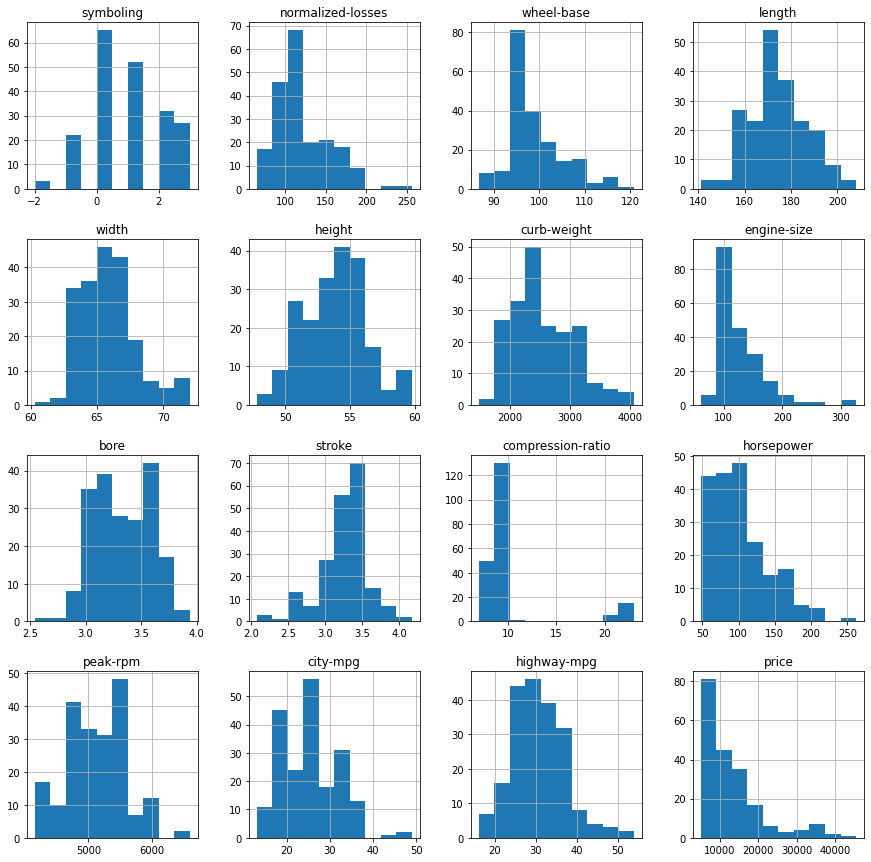

In [ ]:
# se comienza el análisis examinando los histogramas de las
# propiedades numéricas para tener una visión general de las distribuciones
df[numeric_feature_names].hist(ax = plt.figure(figsize = (15, 15)).gca())

De estos histogramas podemos identificar varias desviaciones positivas (p. ej.,
normalized-losses o engine-size) ocasionadas por algunos valores atípicos. Para
mejorar las distribuciones, se procede a aplicar algunas transformaciones a
aquellas propiedades que presentan valores atípicos extremos.

En primer lugar, se tendrá qué identificar cuáles son esos valores atípicos extremos. Para ello, podemos utilizar los diagramas de cajas (boxplots) para visualizarlos y confirmar que existen. Para dibujarlos, podemos hacerlo fácilmente utilizando la biblioteca seaborn.

In [ ]:
# mediante esta función de pueden visualizar los 'outliers'
def draw_hist_boxplot(df, feature_name):
  # se dibuja el diagrama de cajas
  sns.boxplot(x = feature_name, data = df)
  # se dibujan sobre el diagrama todos los puntos de datos que tiene la propiedad
  sns.stripplot(x = feature_name, data = df, color = "#474646")

# mediante esta función se reemplazan todos los outliers
# cualquier valor por encima o por debajo de los
# límites superior o inferior es sustituido por la mediana
def replace_outliers_with_median(df, feature_name):
  Q1 = df[feature_name].quantile(0.25)
  median = df[feature_name].quantile(0.5)
  Q3 = df[feature_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_whisker = Q1 - 1.5 * IQR
  upper_whisker = Q3 + 1.5 * IQR
  df[feature_name] = np.where((df[feature_name] < lower_whisker) | 
                              (df[feature_name] > upper_whisker), 
                                median, 
                                df[feature_name])

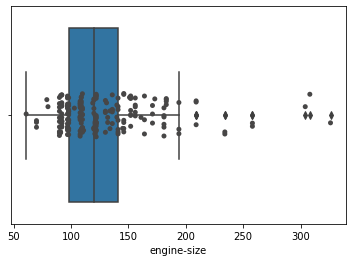

In [ ]:
# se dibuja el diagrama y los puntos
draw_hist_boxplot(df, 'engine-size')

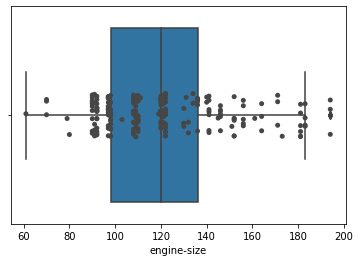

In [ ]:
# se reemplazan los outliers y se vuelve a dibujar
replace_outliers_with_median(df, 'engine-size')
draw_hist_boxplot(df, 'engine-size')

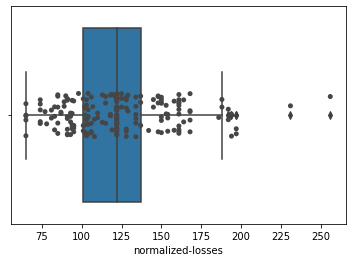

In [ ]:
draw_hist_boxplot(df, 'normalized-losses')

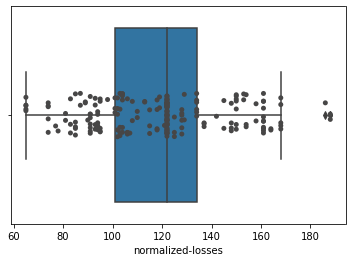

In [ ]:
# se reemplazan los outliers y se vuelve a dibujar
replace_outliers_with_median(df, 'normalized-losses')
draw_hist_boxplot(df, 'normalized-losses')

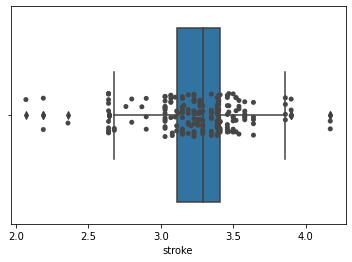

In [ ]:
# dibujar atributo stroke
draw_hist_boxplot(df, 'stroke')

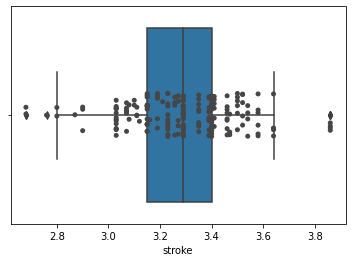

In [ ]:
# reemplazar outliers de stroke y volver a dibujar
replace_outliers_with_median(df, 'stroke')
draw_hist_boxplot(df, 'stroke')

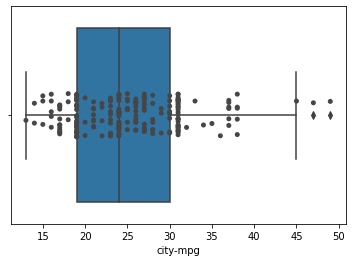

In [ ]:
# atributo city-mpg
draw_hist_boxplot(df, 'city-mpg')

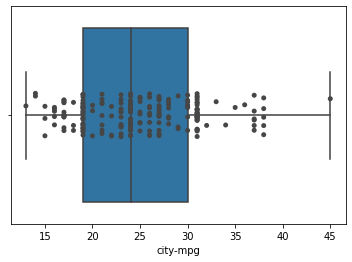

In [ ]:
# en la propiedad city-mpg podremos ver cómo sólo hay algunos pocos valores atípicos
# como son pocos, simplemente los eliminaremos del conjunto de datos

VALOR_OUTLIER = 45
df.drop(df.loc[df['city-mpg'] > VALOR_OUTLIER].index, inplace = True)
draw_hist_boxplot(df, 'city-mpg')

In [ ]:
# repetir para los todos los atributos numéricos:
# compression-ratio, engine-size, peak-rpm, horsepower, etc.
for col in numeric_feature_names:
    replace_outliers_with_median(df, col)

<ipython-input-67-9d0ec4ee150d>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[numeric_feature_names].hist(ax = plt.figure(figsize = (15, 15)).gca())


array([[<AxesSubplot:title={'center':'symboling'}>,
        <AxesSubplot:title={'center':'normalized-losses'}>,
        <AxesSubplot:title={'center':'wheel-base'}>,
        <AxesSubplot:title={'center':'length'}>],
       [<AxesSubplot:title={'center':'width'}>,
        <AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'curb-weight'}>,
        <AxesSubplot:title={'center':'engine-size'}>],
       [<AxesSubplot:title={'center':'bore'}>,
        <AxesSubplot:title={'center':'stroke'}>,
        <AxesSubplot:title={'center':'compression-ratio'}>,
        <AxesSubplot:title={'center':'horsepower'}>],
       [<AxesSubplot:title={'center':'peak-rpm'}>,
        <AxesSubplot:title={'center':'city-mpg'}>,
        <AxesSubplot:title={'center':'highway-mpg'}>,
        <AxesSubplot:title={'center':'price'}>]], dtype=object)

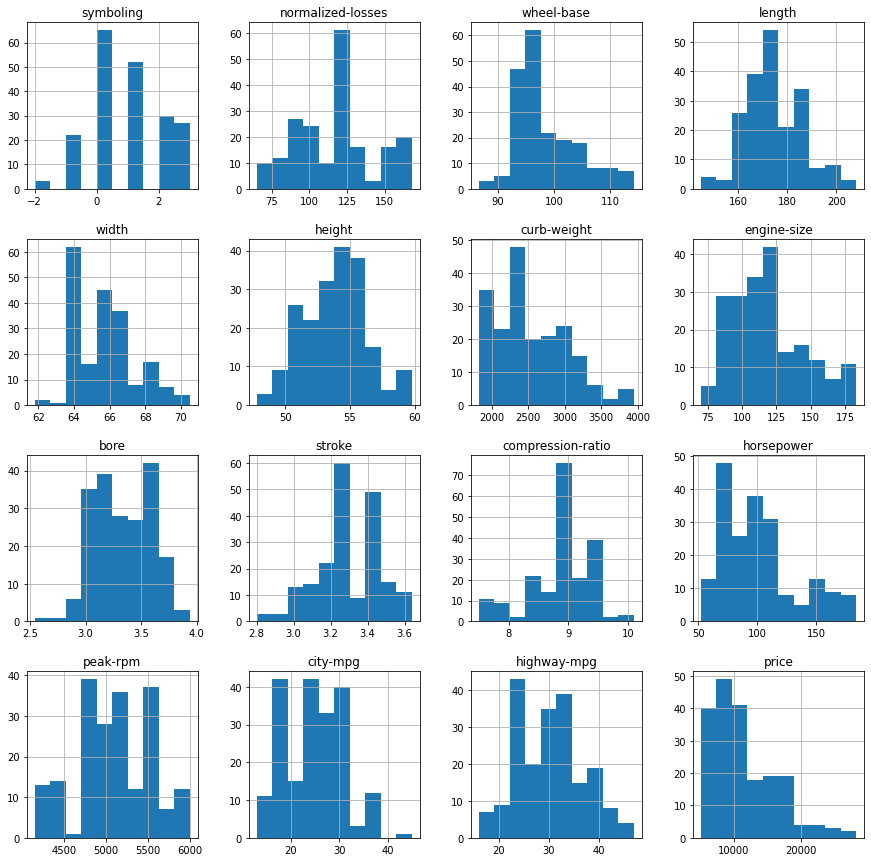

In [ ]:
# una vez que hayamos finalizado, podemos volver a visualizar los histogramas
# para ver que aspecto tienen las nuevas distribuciones
df[numeric_feature_names].hist(ax = plt.figure(figsize = (15, 15)).gca())

En las gráficas puede observarse como las desviaciones se han reducido ligeramente y ya no existen valores atípicos extremos. Para los valores atípicos que nos queden, podemos aplicar la técnica de normalizado mediante escalado z-score. Para ello, podemos utilizar la clase StandardScaler del módulo sklearn.preprocessing y visualizar de nuevo los histogramas para revisar las nuevas distribuciones

<ipython-input-68-6950e0ce55fc>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[numeric_feature_names].hist(ax = plt.figure(figsize = (15, 15)).gca())


array([[<AxesSubplot:title={'center':'symboling'}>,
        <AxesSubplot:title={'center':'normalized-losses'}>,
        <AxesSubplot:title={'center':'wheel-base'}>,
        <AxesSubplot:title={'center':'length'}>],
       [<AxesSubplot:title={'center':'width'}>,
        <AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'curb-weight'}>,
        <AxesSubplot:title={'center':'engine-size'}>],
       [<AxesSubplot:title={'center':'bore'}>,
        <AxesSubplot:title={'center':'stroke'}>,
        <AxesSubplot:title={'center':'compression-ratio'}>,
        <AxesSubplot:title={'center':'horsepower'}>],
       [<AxesSubplot:title={'center':'peak-rpm'}>,
        <AxesSubplot:title={'center':'city-mpg'}>,
        <AxesSubplot:title={'center':'highway-mpg'}>,
        <AxesSubplot:title={'center':'price'}>]], dtype=object)

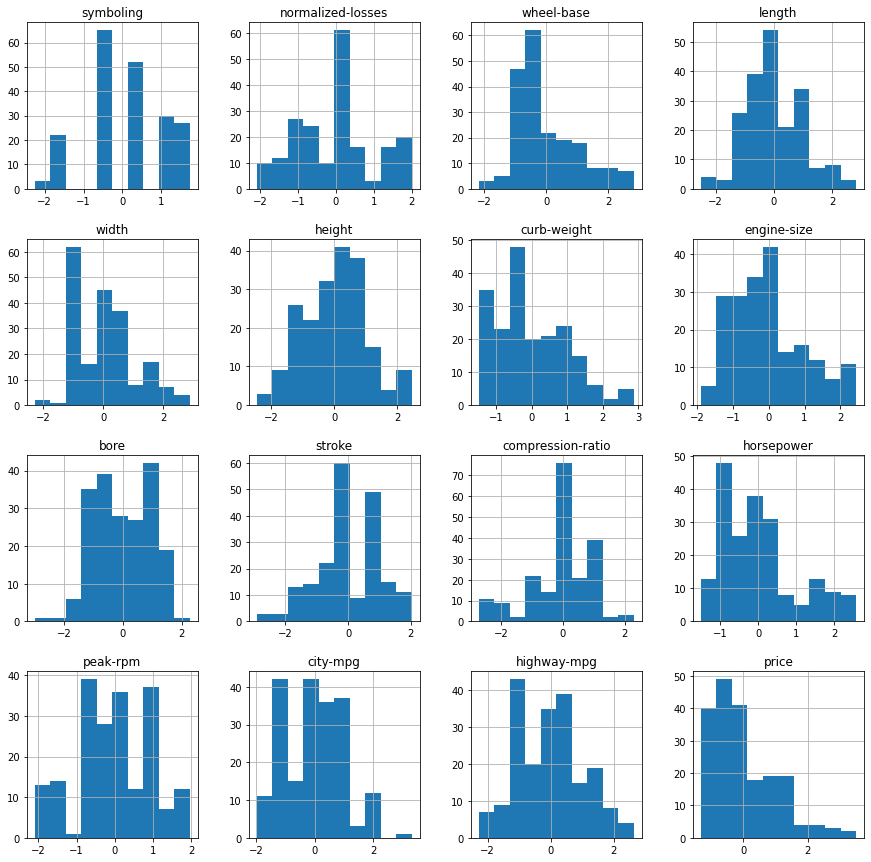

In [ ]:
scaler = StandardScaler()
df[numeric_feature_names] = scaler.fit_transform(df[numeric_feature_names])
df[numeric_feature_names].hist(ax = plt.figure(figsize = (15, 15)).gca())

#### Importancia de las propiedades

Vamos a analizar ahora el impacto de las propiedades sobre la variable objetivo. Para ello, vamos a empezar por las propiedades numéricas. Podemos realizar este análisis inicial mediante un mapa de calor que muestre las correlaciones que existen entre todas las variables, utilizando el método heatmap() del módulo seaborn e indicando que utilice la correlación de Pearson para ello.

<AxesSubplot:>

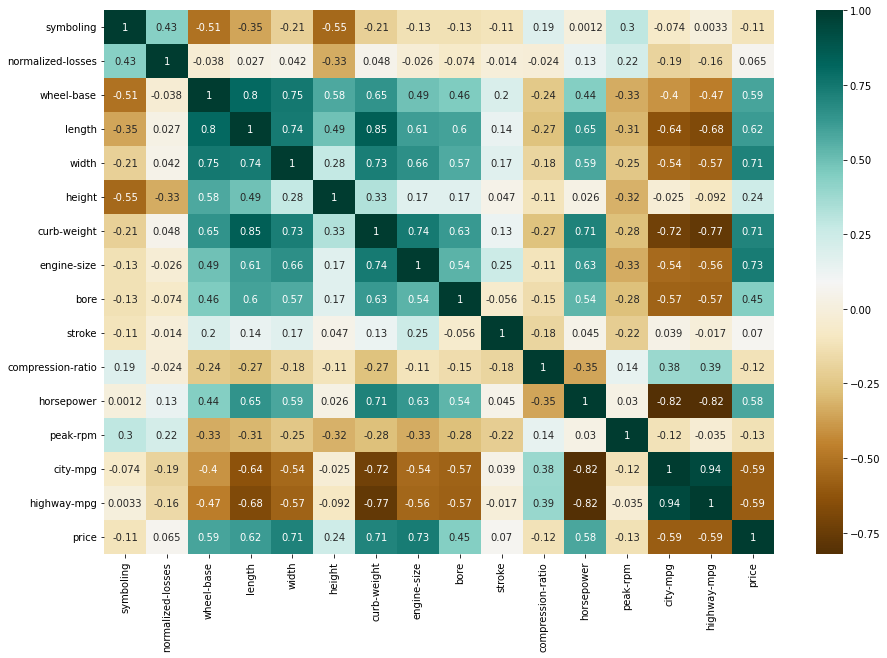

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), cmap = 'BrBG', annot = True)

In [ ]:
# podemos utilizar el análisis para eliminar algunas propiedades que no
# tengan ninguna correlación con la variable objetivo: symboling
df = df.drop('symboling', axis=1)
numeric_feature_names.remove('symboling')

Sobre las variables categóricas, se pueden visualizar sus diagramas de cajas
para analizar sus distribuciones en relación al precio.

<AxesSubplot:xlabel='body-style', ylabel='price'>

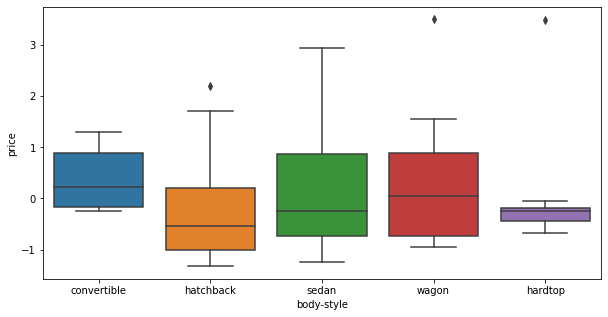

In [ ]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'body-style', y = 'price', data = df)

<AxesSubplot:xlabel='aspiration', ylabel='price'>

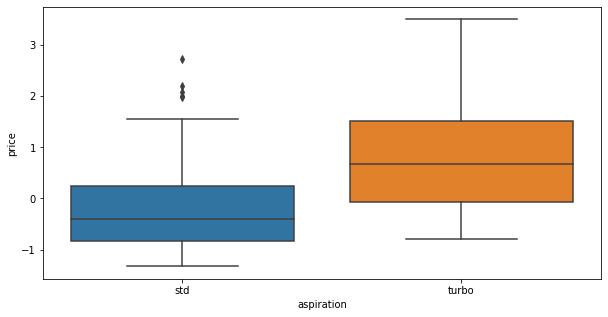

In [ ]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'aspiration', y = 'price', data = df)

<AxesSubplot:xlabel='fuel-system', ylabel='price'>

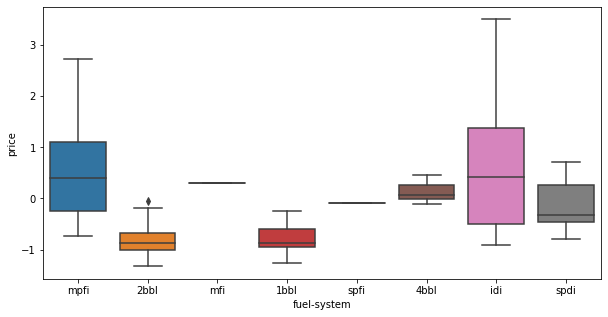

In [ ]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'fuel-system', y = 'price', data = df)

<AxesSubplot:xlabel='drive-wheels', ylabel='price'>

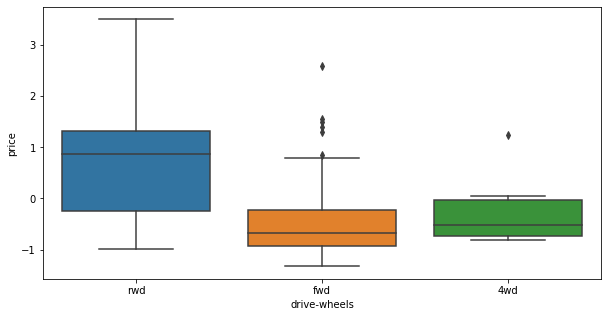

In [ ]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'drive-wheels', y = 'price', data = df)

#### Codificación de las variables categóricas

In [ ]:
print(f'Propiedades numéricas: {numeric_feature_names} ({len(numeric_feature_names)})')
print(f'Propiedades categóricas: {categorical_feature_names} ({len(categorical_feature_names)})')

all_feature_names = numeric_feature_names + categorical_feature_names

Propiedades numéricas: ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price'] (15)
Propiedades categóricas: ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system'] (10)


In [ ]:
df[numeric_feature_names].head(2)

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.176781,-1.813923,-0.478688,-0.928002,-2.039,-0.001487,0.404357,0.508934,-0.025759,0.171938,0.315159,-0.231193,-0.656758,-0.534335,0.420953
1,0.176781,-1.813923,-0.478688,-0.928002,-2.039,-0.001487,0.404357,0.508934,-0.025759,0.171938,0.315159,-0.231193,-0.656758,-0.534335,1.048372


In [ ]:
df[categorical_feature_names].head(2)

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system
0,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi




---



In [ ]:
le = preprocessing.LabelEncoder()

for column in categorical_feature_names:
    df[column] = le.fit_transform(df[column])

In [ ]:
df.head(2)

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.176781,0,1,0,1,0,2,0,-1.813923,-0.478688,...,0.404357,5,0.508934,-0.025759,0.171938,0.315159,-0.231193,-0.656758,-0.534335,0.420953
1,0.176781,0,1,0,1,0,2,0,-1.813923,-0.478688,...,0.404357,5,0.508934,-0.025759,0.171938,0.315159,-0.231193,-0.656758,-0.534335,1.048372


##3. Separar datos de entrada y salida

In [ ]:
# separamos los datos entre datos de entrada y salida
X = df.drop('price', axis=1)
y = df['price']

# separamos los datos entre entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=1)

## 4.  Entrenamiento, predicción y evaluación del modelo 

### Regresión Lineal

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# precisión del modelo con los datos de entrenamiento
model.score(X_train, y_train)

0.7888664892105955

In [ ]:
# precisión con los datos de test
model.score(X_test, y_test)

0.6595637783826006

In [ ]:
# precisón con los datos de prueba
y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.6595637783826006

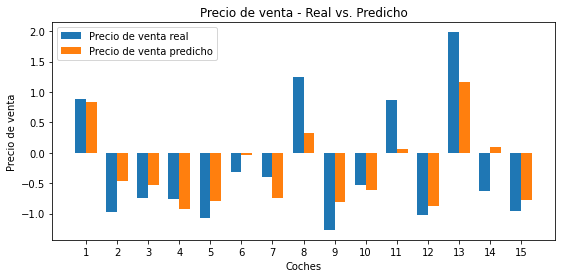

In [ ]:
# representando las predicciones para los datos de prueba de los
# 15 primeros coches

ind = np.arange(15)
width = 0.35

plt.figure(figsize = (9, 4))
plt.bar(ind, y_test[:15], width, label = 'Precio de venta real')
plt.bar(ind+width, y_pred[:15], width, label = 'Precio de venta predicho')

plt.xticks(ind+width / 2, np.arange(1, 16))
plt.legend(loc = 'best')

plt.xlabel('Coches')
plt.ylabel('Precio de venta')
plt.title('Precio de venta - Real vs. Predicho')

plt.show()

### Red Neuronal

In [ ]:
num_columnas = X_train.shape[1]
print(num_columnas)

24


In [ ]:
# instanciamos al modelo
model = Sequential()
model.add(Dense(num_columnas, input_dim=num_columnas, activation='relu')) # la capa de entrada tiene las mismas neuronas que el tamaño de los datos, a continuacion va una capa con 12 neuronas
model.add(Dense(num_columnas/2, activation='relu')) # capa intermedia con 8 neuronas
model.add(Dense(1, activation='linear'))

# compilamos el modelo
model.compile(loss='mean_squared_error', 
              optimizer='adam')

# entrenamiento
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=10)

Epoch 1/30
15/15 [==============================] - 3s 54ms/step - loss: 5.0797 - val_loss: 1.9009
Epoch 2/30
15/15 [==============================] - 0s 4ms/step - loss: 1.3619 - val_loss: 0.5456
Epoch 3/30
15/15 [==============================] - 0s 5ms/step - loss: 0.9341 - val_loss: 0.2984
Epoch 4/30
15/15 [==============================] - 0s 5ms/step - loss: 0.7883 - val_loss: 0.2541
Epoch 5/30
15/15 [==============================] - 0s 6ms/step - loss: 0.6949 - val_loss: 0.2512
Epoch 6/30
15/15 [==============================] - 0s 5ms/step - loss: 0.6180 - val_loss: 0.2284
Epoch 7/30
15/15 [==============================] - 0s 5ms/step - loss: 0.5647 - val_loss: 0.2358
Epoch 8/30
15/15 [==============================] - 0s 5ms/step - loss: 0.5136 - val_loss: 0.2279
Epoch 9/30
15/15 [==============================] - 0s 5ms/step - loss: 0.4793 - val_loss: 0.2312
Epoch 10/30
15/15 [==============================] - 0s 4ms/step - loss: 0.4635 - val_loss: 0.2358
Epoch 11/30
15/15 

In [ ]:
# Evaluar el rendimiento del modelo en los datos de prueba
mse = model.evaluate(X_test, y_test)
print(f"Pérdida del modelo en los datos de prueba (mse): {mse:.4f}")

2/2 [==============================] - 0s 12ms/step - loss: 0.1529
Pérdida del modelo en los datos de prueba (mse): 0.1529


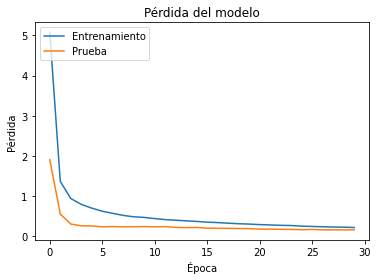

In [ ]:
# Graficar la pérdida del modelo durante el entrenamiento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
plt.show()